# CUADS Data Quality Notebook

## About CUADS
CUADS is a multimodal dataset contained ECG, PPG and GSR physiological signals recorded while participants viewed pre-tagged affective movie clips. After each movie clip, participants completed a SAM survey to evaluate arousal and valence.

The dataset can obtained from IEEE DataPort here: [https://ieee-dataport.org/documents/clarkson-university-affective-dataset-cuads](https://ieee-dataport.org/documents/clarkson-university-affective-dataset-cuads)


## About this notebook
This notebook is used to perform quality assessment of the data contained in CUADS. We evaluate and score each of the three physiological signals, and the SAM survey response data.

## Instructions
Download and extract the CUADS dataset. In the first cell, update the value `dataset_root` to path to the `cuads` folder in the extracted dataset. This notebook produces several output images. The path to save the output can be set in the `dataset_output` variable, and defaults to `./output`.

For help, please reach out to the authors.

In [1]:
import os
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

# Path to the extracted dataset
dataset_root='./dataset/cuads'

# Path to write output images and numpy files
dataset_output=f'./output'

if not os.path.exists(dataset_root):
    print("ERROR: No dataset found at {dataset_root}")

if not os.path.exists(dataset_output):
    os.mkdir(dataset_output)

In [2]:
Fs=256                      # Physiological signal sampling rate. DO NOT MODIFY.
CUADS_NUM_PARTICIPANTS=44   # CUADS enrolled 44 participants.
CUADS_NUM_MOVIECLIPS=20     # Participants were each shown 20 movie clips

# ECG Scoring

The following cell scores the ECGs using NeuroKit2. NeuroKit2 ontains several methods for cleaning an ECG, listed in the `methods` list. The Zhoe2018 method scores the cleaned ECG, rating them as `unacceptable`, `barely acceptable` or `excellent`

For each ecg signal in the dataset, we attempt to find the NeuroKit2 method that results in the highest quality score.

__NOTE:__ in the Data Descriptor submitted to IEEE-Data, we only report quality results using the `neurokit` Method. This method applies a 0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering (nk defaults to 50 Hz, we specify 60Hz in the call to override). Below, we search all available methods and achieve "Excellent" scoring for all 714 samples in the dataset


In [3]:
# Map column numbers to ECG Channel Names - only used for logging
column_to_channel_name = {15: "LA-RA", 16: "LL-LA", 17: "LL-RA"}

# Map Zhao2018 result labels to integer values
quality_map = { "Unacceptable": 0, "Barely acceptable": 1, "Excellent": 2 }

# List of methods for ECG Cleaning in NeuroKit2
methods = ["neurokit", "biosppy", "pantompkins1985", "hamilton2002", "elgendi2010", "engzeemod2012", "vg"]

# Used to track how many times each method resulted in the best score for each signal
bestmethod_counts = {"neurokit": 0, "biosppy": 0, "pantompkins1985": 0, "hamilton2002": 0, "elgendi2010": 0, "engzeemod2012": 0, "vg": 0}

# Used to track how many ecg signals received each score
quality_results = { 0: 0, 1: 0, 2: 0 }

# Used to track the best scores by ecg-channel
quality_by_channel = {0: { 0: 0, 1: 0, 2: 0 }, 1: { 0: 0, 1: 0, 2: 0 }, 2: { 0: 0, 1: 0, 2: 0 } }

for p in range(CUADS_NUM_PARTICIPANTS):
    folder = f"{dataset_root}/CUADS_{(p+1):03}"
    if not os.path.exists(folder):
        continue

    # Load this participant's responses...
    responses = np.loadtxt(f"{folder}/responses.csv", delimiter=',', dtype=str, skiprows=1)

    for c, response in enumerate(responses):
        movie_name = response[0]
        segmented_data_filepath = f'{folder}/segmented/{movie_name}_sessiondata.csv'
        if not os.path.exists(segmented_data_filepath):
            #print(f"No segmented datafile found: {segmented_data_filepath}")
            continue

        segmented_data = np.loadtxt(segmented_data_filepath, delimiter=',', dtype=str, skiprows=1)

        ## ECG LA-RA 24-Bit = Column 16
        ## ECG LL-LA 24-Bit = Column 17
        ## ECG LL-RA 24-Bit = Column 18
        for channel in np.arange(15,18):
            quality = "x"
            channel_dat=segmented_data[:,channel]
            channel_dat = np.array(channel_dat, dtype=np.float64)

            methodidx = 0
            best_quality = -1
            best_quality_method = ""

            # Loop until we get an "Excellent" result, or run out of methods to test...
            while quality != "Excellent" and methodidx < len(methods):
                current_method = methods[methodidx]

                # Clean the ECG signal using the current method
                ecg_cleaned = nk.ecg_clean(channel_dat, sampling_rate=Fs, powerline=60, method=current_method)

                # Evaluate the ECG signal using fuzzy comprehensive SQI evaluation
                quality = nk.ecg_quality(ecg_cleaned, sampling_rate=Fs, method='zhao2018', approach="fuzzy")

                # Is this better than the best one we've found so far?
                if quality_map[quality] > best_quality:
                    best_quality = quality_map[quality]
                    best_quality_method = current_method

                methodidx += 1

            quality_by_channel[channel-15][best_quality] += 1
            bestmethod_counts[best_quality_method] += 1
            quality_results[best_quality] += 1

            #print(f"Participant {p+1} Video {c} Channel {column_to_channel_name[channel]}: Best Method {best_quality_method}, Best Quality: {best_quality}")

print("\nECG Signal Counts by Best Quality (0=Unacceptable, 1=Barely acceptable, 2=Excellent)")
print(quality_results)

print("\nECG Signal Counts by Best Method")
print(bestmethod_counts)

print("\nECG Signal Counts by By ECG-Channel (0=LA-RA, 1=LL-LA, 2=LL-RA)")
print(quality_by_channel)


ECG Signal Counts by Best Quality (0=Unacceptable, 1=Barely acceptable, 2=Excellent)
{0: 0, 1: 0, 2: 2142}

ECG Signal Counts by Best Method
{'neurokit': 1824, 'biosppy': 100, 'pantompkins1985': 156, 'hamilton2002': 62, 'elgendi2010': 0, 'engzeemod2012': 0, 'vg': 0}

ECG Signal Counts by By ECG-Channel (0=LA-RA, 1=LL-LA, 2=LL-RA)
{0: {0: 0, 1: 0, 2: 714}, 1: {0: 0, 1: 0, 2: 714}, 2: {0: 0, 1: 0, 2: 714}}


# PPG Scoring

We score PPG by looking at the heartrate inferred from PPG, and computing the euclidean distance to the average heartrate computed across the 3 ECG channels. We then score them on their distance from ECG_HR based on the mean and stdev of the distances.

If d < mean - stdev (between 0 and 1 stdev less tham mean), it is excellent
if (mean-stdev) <= d <= (mean+stdev), it is good
if d > (mean~stdev), it is poor

```
Let m be the mean distance
Let s be the stdev of the distances

  |----- EXCELLENT ----|--- GOOD ----|----- POOR -------|
  |--------------------|------+------|------------------|
min(d)               (m-s)    m    (m+s)              max(d)

In [4]:
hr_distances = []

for p in range(CUADS_NUM_PARTICIPANTS):
    folder = f"{dataset_root}/CUADS_{(p+1):03}"
    if not os.path.exists(folder):
        continue

    # Load this participant's responses...
    responses = np.loadtxt(f"{folder}/responses.csv", delimiter=',', dtype=str, skiprows=1)

    for response in responses:
        movie_name = response[0]
        segmented_data_filepath = f'{folder}/segmented/{movie_name}_sessiondata.csv'
        if not os.path.exists(segmented_data_filepath):
            print(f"No segmented datafile found: {segmented_data_filepath}")
            continue

        segmented_data = np.loadtxt(segmented_data_filepath, delimiter=',', dtype=str, skiprows=1)

        ## ECG LA-RA HR = Column 20
        ## ECG LL-LA HR = Column 21
        ## ECG LL-RA HR = Column 22
        ## PPG HR       = Column 48

        ecg_avg_hr = np.array(segmented_data[:,19:21],dtype=float).mean(axis=1)
        ppg_hr = np.array(segmented_data[:,47],dtype=float)
        hr_distances.append(np.sqrt(np.sum(np.square(ecg_avg_hr-ppg_hr))))

print("Heart Rate Stats:")
hr_distances = np.array(hr_distances)
mu = np.mean(hr_distances)
sigma = np.std(hr_distances)
print(f"Min: {np.min(hr_distances)})")
print(f"Max: {np.max(hr_distances)}")
print(f"Stdev: {sigma}")
print(f"Mean: {mu}")
print("\nScores:")
print(f"Poor: {len([ d for d in hr_distances if d > (mu+sigma)])}")
print(f"Good: {len([ d for d in hr_distances if (mu-sigma) <= d <= (mu+sigma)])}")
print(f"Excellent: {len([ d for d in hr_distances if d < (mu-sigma)])}")



Heart Rate Stats:
Min: 172.04682234675633)
Max: 15975.490744169096
Stdev: 3569.5163257874947
Mean: 4812.012427308758

Scores:
Poor: 128
Good: 477
Excellent: 109


# GSR Scoring

Implemented across the next two cells

We score GSR based on RMSE of the Skin Conductance signals. We calculate a reference signal for each participant by averaging skin conductance for all samples from that participant. We then compute the distance from baseline for each signal and rate them as `poor`, `good` or `excellent` based on distance from the mean.

In [5]:
gsr_signals_by_participant = {}

# Load each GSR-SC signal by participant...
for p in range(CUADS_NUM_PARTICIPANTS):
    folder = f"{dataset_root}/CUADS_{(p+1):03}"
    if not os.path.exists(folder):
        continue

    # Load this participant's responses...
    responses = np.loadtxt(f"{folder}/responses.csv", delimiter=',', dtype=str, skiprows=1)

    # Create a list to hold the GSR signals for this participant...
    gsr_signals_by_participant[p] = []

    for c, response in enumerate(responses):
        movie_name = response[0]
        segmented_data_filepath = f'{folder}/segmented/{movie_name}_sessiondata.csv'
        if not os.path.exists(segmented_data_filepath):
            print(f"No segmented datafile found: {segmented_data_filepath}")
            continue

        segmented_data = np.loadtxt(segmented_data_filepath, delimiter=',', dtype=str, skiprows=1)

        ## GSR Skin Conductance = Column 37
        skin_conductance = np.array(segmented_data[:,36],dtype=float)
        gsr_signals_by_participant[p].append(skin_conductance)

In [6]:
rmse_results = {}

for participant, gsr_signals in gsr_signals_by_participant.items():
    # Determine the maximum length of segmented data files for this participant
    max_length = max(len(gsr_signal) for gsr_signal in gsr_signals)

    # Pad all segmented data files to the maximum length with zeros
    padded_datasets = [np.pad(gsr_signal, (0, max_length - len(gsr_signal)), mode='constant') for gsr_signal in gsr_signals]

    # Compute the reference signal (mean across padded datasets)
    reference_signal = np.mean(padded_datasets, axis=0)

    # Compute normalized RMSE for each segmented data file
    rmses = []
    for gsr_signal in gsr_signals:
        T_i = len(gsr_signal)  # Actual length of the dataset
        padded_dataset = np.pad(gsr_signal, (0, max_length - T_i), mode='constant')  # Pad to match reference length
        rmse = np.sqrt(np.sum((padded_dataset[:T_i] - reference_signal[:T_i]) ** 2) / T_i)  # Normalize by T_i
        rmses.append(rmse)

    # Compute thresholds for classification
    mu = np.mean(rmses)  # Mean of RMSE values
    sigma = np.std(rmses)  # Standard deviation of RMSE values

    classifications = []
    for rmse in rmses:
        if rmse < mu - sigma:
            classifications.append("Excellent")
        elif mu - sigma <= rmse <= mu + sigma:
            classifications.append("Good")
        else:
            classifications.append("Poor")

    # Store results and classifications for the participant
    rmse_results[participant] = {
        "RMSE Values": rmses,
        "Classifications": classifications
    }

# Convert results into a DataFrame for easier analysis
participant_results = []
for participant, results in rmse_results.items():
    for i, (rmse, classification) in enumerate(zip(results["RMSE Values"], results["Classifications"])):
        participant_results.append({
            "Participant": participant,
            "Segmented File ID": i + 1,
            "RMSE": rmse,
            "Classification": classification
        })

# Create a DataFrame from the results
results_df = pd.DataFrame(participant_results)

# Display the results in tabular format
# Count the total number of each classification
classification_counts = results_df["Classification"].value_counts()

# Display the counts
print("Total Classifications:")
print(classification_counts)

Total Classifications:
Classification
Good         491
Poor         132
Excellent     91
Name: count, dtype: int64


# Participant Response Evaluation

We consider Randolph's Kappa to assess intra-rater agreement of all participants for each movie clip. We expect better than chance agreement and hope to fair-to-moderate agreement based on other studies.

We also consider how participants' classification of each movie clip matches the expected classification label (where movies are classified into Quadrants 1, 2, 3 or 4 on the Valence-Arousal space). Confusion matrices are generated to visualize this information.

In [7]:
participant_responses_quadrant = np.zeros(shape=(CUADS_NUM_PARTICIPANTS, CUADS_NUM_MOVIECLIPS), dtype=int)
expected_responses_quadrant = np.zeros(shape=(CUADS_NUM_MOVIECLIPS), dtype=int)

expected_label_map = {
    np.str_('video_55'): 2,
    np.str_('video_79'): 1,
    np.str_('video_111'): 3,
    np.str_('video_73'): 2,
    np.str_('video_52'): 4,
    np.str_('video_146'): 3,
    np.str_('video_funny_f'): 1,
    np.str_('video_80'): 1,
    np.str_('video_cats_f'): 1,
    np.str_('video_138'): 3,
    np.str_('video_69'): 2,
    np.str_('video_dallas_f'): 0,
    np.str_('video_detroit_f'): 0,
    np.str_('video_53'): 4,
    np.str_('video_58'): 4,
    np.str_('video_30'): 2,
    np.str_('video_earworm_f'): 2,
    np.str_('video_newyork_f'): 0,
    np.str_('video_90'): 1,
    np.str_('video_107'): 2
}

# Since participants viewed movies in a random order we need
# to track what sequence we encounter the movies in during processing,
# so that we have consistent indexing later.
movie_idx_map={}
movie_idx = 0

def to_quadrant(a, v):
    q = -1
    if a >= 5:
        if v >= 5:
            q = 1
        else:
            q = 2
    else:
        if v < 5:
            q = 3
        else:
            q = 4
    return q

for p in range(CUADS_NUM_PARTICIPANTS):
    folder = f"{dataset_root}/CUADS_{(p+1):03}"
    if not os.path.exists(folder):
        continue

    responses = np.loadtxt(f"{folder}/responses.csv", delimiter=',', dtype=str, skiprows=1)

    for c, response in enumerate(responses):
        movie_name = response[0]

        # If we haven't indexed this movie yet, add it to the movie_idx_map
        # and also index its expected response accordingly
        if movie_name not in movie_idx_map:
            movie_idx_map[movie_name]=movie_idx
            expected_responses_quadrant[ movie_idx] = expected_label_map[movie_name]
            movie_idx+=1

        v=float(response[1])
        a=float(response[2])

        participant_responses_quadrant[p][movie_idx_map[movie_name]] = to_quadrant(a, v)


def convert_quadrant_to_arousal(value):
    if value == 0:
        return 0
    elif value in [1, 2]:
        return 1
    elif value in [3, 4]:
        return -1

def convert_quadrant_to_valence(value):
    if value == 0:
        return 0
    elif value in [1, 4]:
        return 1
    elif value in [2, 3]:
        return -1


# Apply the conversion
participant_responses_arousal = np.vectorize(convert_quadrant_to_arousal)(participant_responses_quadrant)
participant_responses_valence = np.vectorize(convert_quadrant_to_valence)(participant_responses_quadrant)
expected_responses_arousal = np.vectorize(convert_quadrant_to_arousal)(expected_responses_quadrant)
expected_responses_valence = np.vectorize(convert_quadrant_to_valence)(expected_responses_quadrant)

In [8]:
def plot_kappa_scores( kappa_input, title ):
    kappa_scores = []
    for i in range(kappa_input.shape[0]):
        clip_input = kappa_input[i:i + 1, :]  # Extract one row for the current clip
        if np.sum(clip_input) > 0:  # Ensure there is at least one valid response
            kappa_score = fleiss_kappa(clip_input, method='randolph')
            kappa_scores.append(kappa_score)
        else:
            kappa_scores.append(None)  # Handle empty clips gracefully

    ## Create bar chart for Fleiss' Kappa scores
    clip_indices = list(range(1, len(kappa_scores) + 1))
    data = [score if score is not None else 0 for score in kappa_scores]
    plt.figure(figsize=(10, 6))
    plt.bar(clip_indices, data, color='skyblue')
    plt.xticks(clip_indices)
    plt.xlabel("Movie Clip")
    plt.ylabel("Randolph's Kappa Score")
    plt.title(title)
    plt.ylim(np.min(kappa_scores)*-1.1, 1.1*np.max(np.abs(kappa_scores)))  # Fleiss' Kappa ranges from -1 to 1
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Reference line for 0 agreement
    plt.show()


def prepare_kappa_input( responses ):
    (result, labels) = aggregate_raters(responses.transpose())

    zeroidx = np.where(labels == 0)[0]
    result = np.delete(result, zeroidx, axis=1)

    return result

def pad_kappa_inputs_to_n_raters( kappa_input ):
    n_raters = int(kappa_input.sum(axis=1).max())
    if not np.all(kappa_input.sum(axis=1) == n_raters):
        # Normalize all clips to have the same number of ratings
        for i in range(kappa_input.shape[0]):
            total_responses = int(kappa_input[i].sum())

            if total_responses < n_raters:
                # Add missing responses proportionally based on existing counts
                proportions = kappa_input[i] / total_responses
                missing_responses = n_raters - total_responses
                additional_responses = np.random.multinomial(missing_responses, proportions)

                kappa_input[i] += additional_responses

    return kappa_input

def process_kappa( participant_responses, response_type ):
    # Prepare kappa input based on arousal results
    kappa_input = prepare_kappa_input(participant_responses)
    kappa_input = pad_kappa_inputs_to_n_raters(kappa_input)
    plot_kappa_scores(kappa_input, f"Randolph's Kappa Agreement Scores Across Movie Clips - {response_type}")

    # Calculate Fleiss' Kappa using only non-neutral movies
    kappa_score = fleiss_kappa(kappa_input, method='randolph')
    print("Randolph's Kappa Score:", kappa_score)

    # Identify indices of non-neutral movies
    # Filter the fleiss_input matrix to exclude neutral movies
    non_neutral_movie_indices = [i for i, label in enumerate(expected_responses_quadrant) if label != 0]
    filtered_kappa_input = kappa_input[non_neutral_movie_indices]
    plot_kappa_scores(filtered_kappa_input, f"Randolph's Kappa Agreement Scores Across Non-Neutral Movie Clips - {response_type}")

    # Calculate Randolph's Kappa using only non-neutral movies
    filtered_kappa_score = fleiss_kappa(filtered_kappa_input, method='randolph')
    print("Randolph's Kappa Score (excluding neutral movies):", filtered_kappa_score)


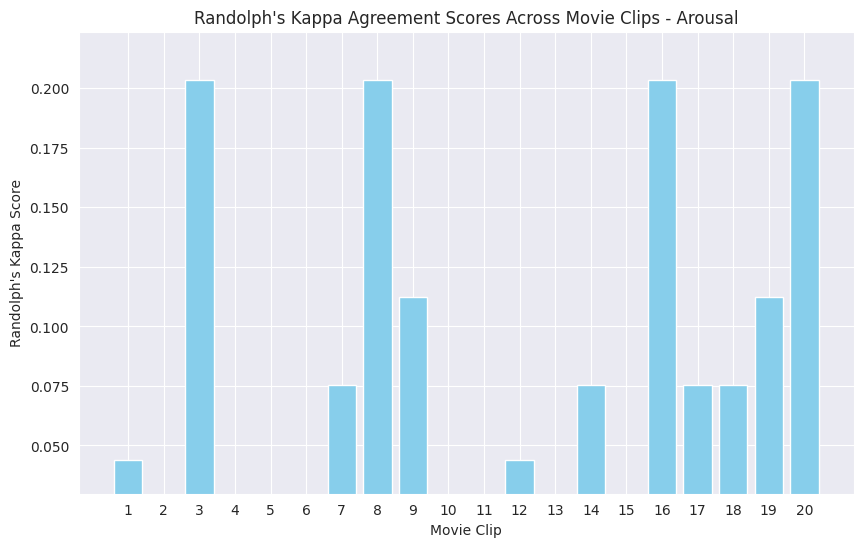

Randolph's Kappa Score: 0.06927453769559033


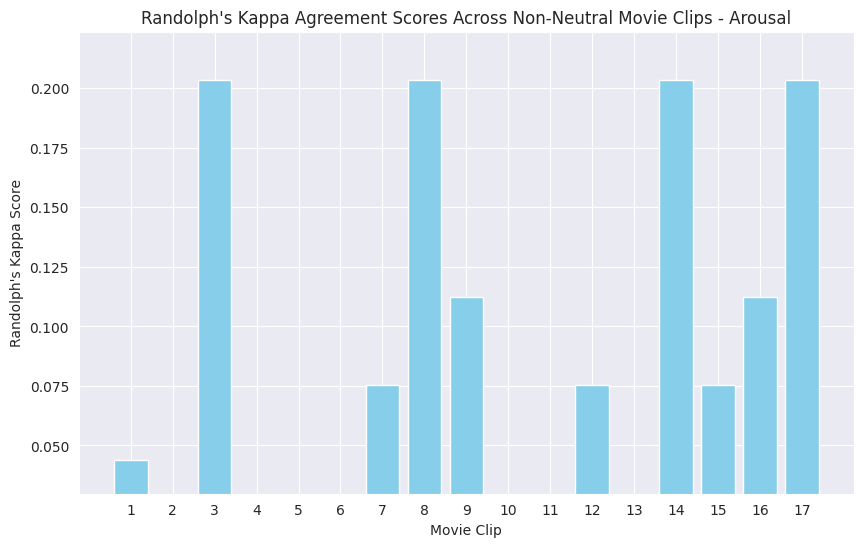

Randolph's Kappa Score (excluding neutral movies): 0.07455443059158218


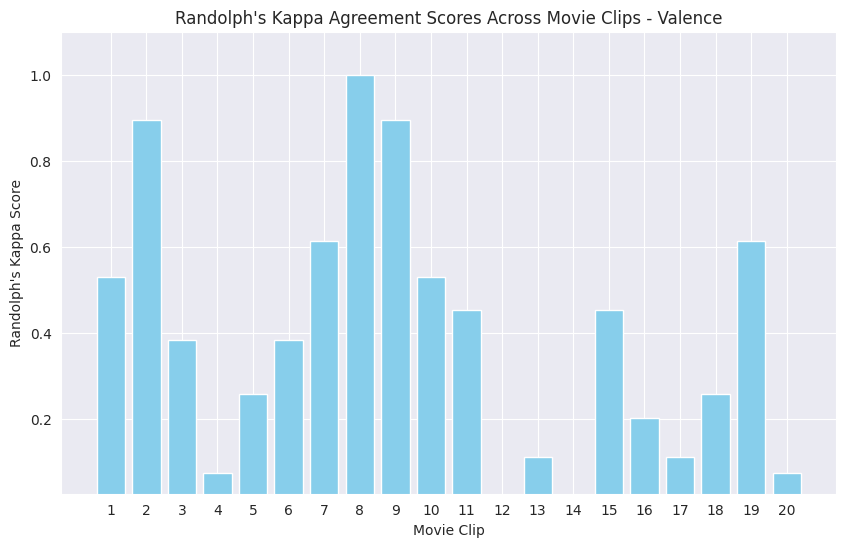

Randolph's Kappa Score: 0.39189189189189166


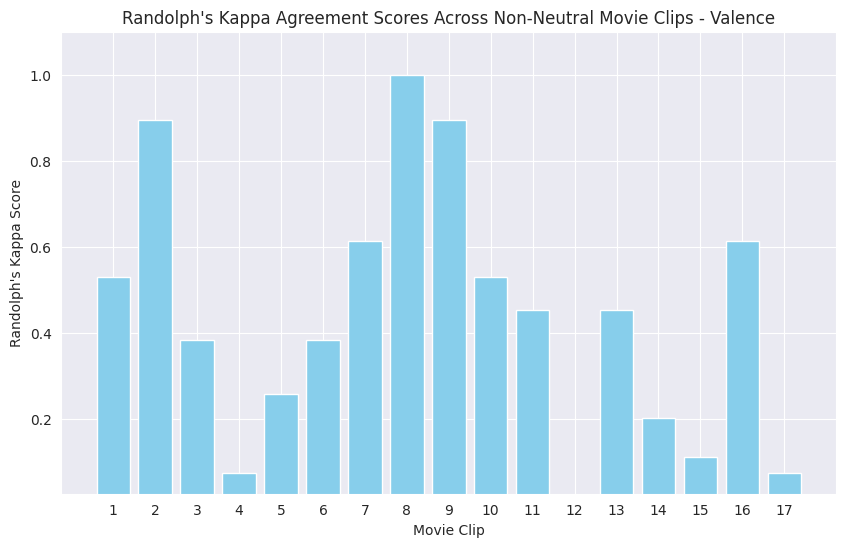

Randolph's Kappa Score (excluding neutral movies): 0.4382060078654506


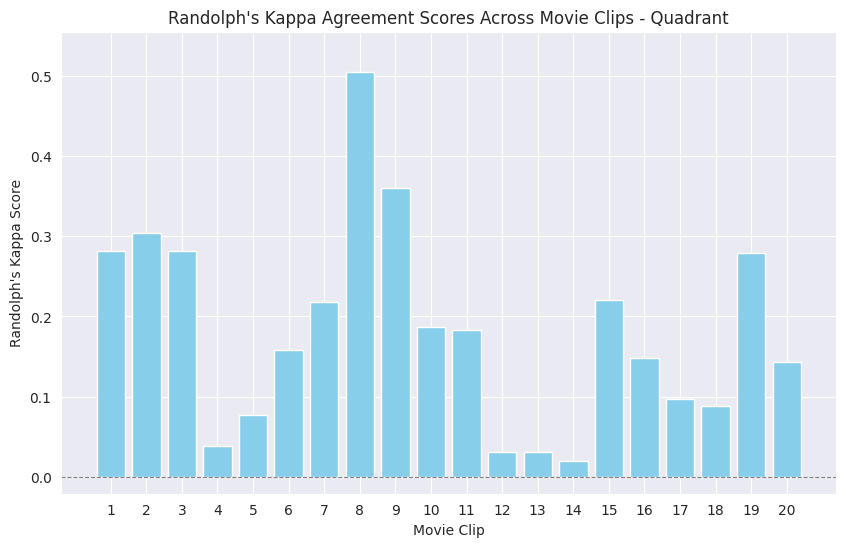

Randolph's Kappa Score: 0.18245614035087718


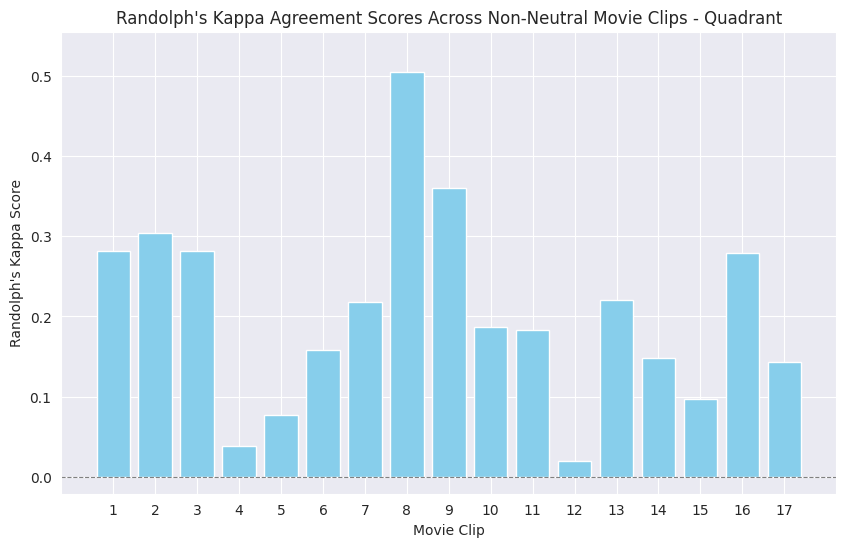

Randolph's Kappa Score (excluding neutral movies): 0.20586840710679724


In [9]:
process_kappa( participant_responses_arousal, "Arousal")
process_kappa( participant_responses_valence, "Valence")
process_kappa(participant_responses_quadrant, "Quadrant")

Accuracy: 0.48
Per-Class Precision: [0.54716981 0.59770115 0.34745763 0.27884615]
Per-Class Recall: [0.63736264 0.48826291 0.38679245 0.27102804]
Macro Precision: 0.44
Macro Recall: 0.45
Weighted Precision: 0.48
Weighted Recall: 0.48

Classification Report:
              precision    recall  f1-score   support

           I       0.55      0.64      0.59       182
          II       0.60      0.49      0.54       213
         III       0.35      0.39      0.37       106
          IV       0.28      0.27      0.27       107

    accuracy                           0.48       608
   macro avg       0.44      0.45      0.44       608
weighted avg       0.48      0.48      0.48       608

Accuracy: 0.58
Per-Class Precision: [0.4009009  0.67875648]
Per-Class Recall: [0.41784038 0.66329114]
Macro Precision: 0.54
Macro Recall: 0.54
Weighted Precision: 0.58
Weighted Recall: 0.58

Classification Report:
              precision    recall  f1-score   support

         Low       0.40      0.42     

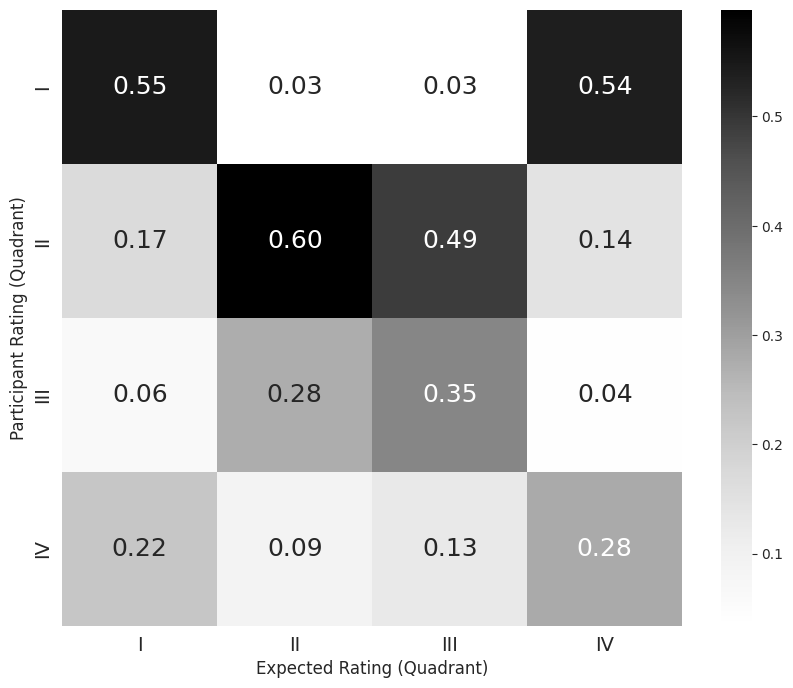

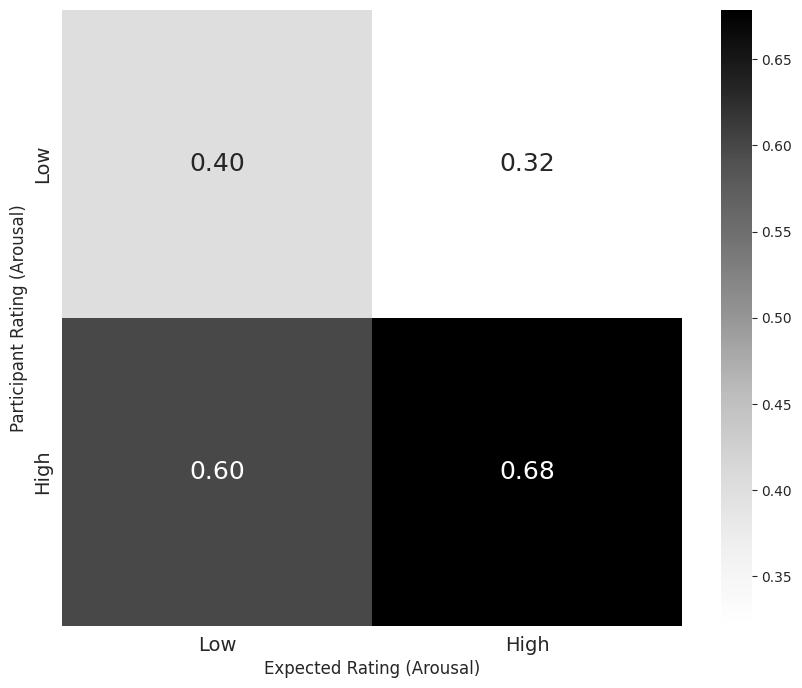

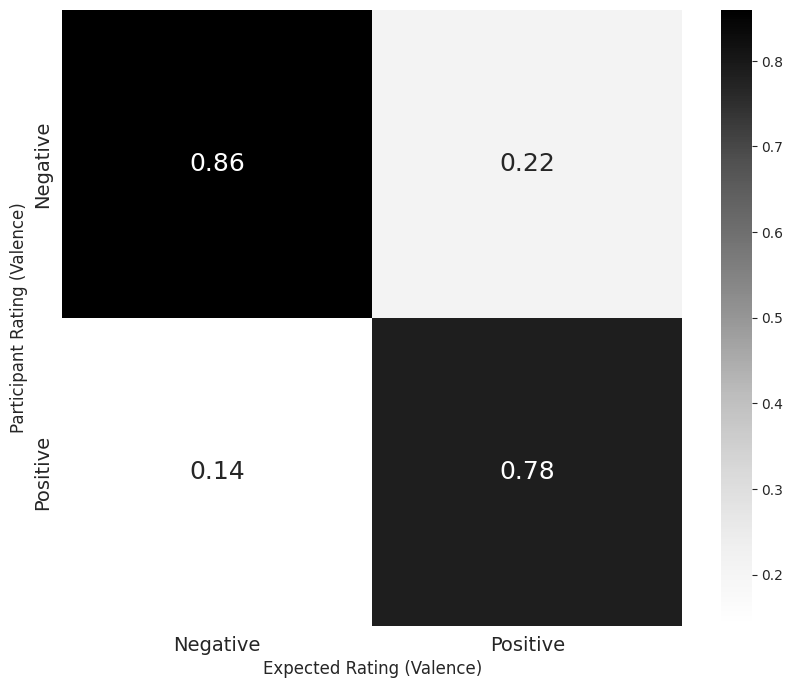

In [12]:

def stats(y_true, y_pred, classes):
    # Compute Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Compute Precision and Recall for Each Class
    precision = precision_score(y_true, y_pred, average=None)  # Per-class precision
    recall = recall_score(y_true, y_pred, average=None)        # Per-class recall

    # Macro and Weighted Averages
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')

    weighted_precision = precision_score(y_true, y_pred, average='weighted')
    weighted_recall = recall_score(y_true, y_pred, average='weighted')

    # Print Results
    print(f"Accuracy: {accuracy:.2f}")
    print("Per-Class Precision:", precision)
    print("Per-Class Recall:", recall)
    print(f"Macro Precision: {macro_precision:.2f}")
    print(f"Macro Recall: {macro_recall:.2f}")
    print(f"Weighted Precision: {weighted_precision:.2f}")
    print(f"Weighted Recall: {weighted_recall:.2f}")

    # Optional: Full Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))


def make_matrix(cm_responses, cm_labels, cm_classes, cm_xlabel, cm_ylabel, fname):
    non_neutral_movie_indices = [i for i, label in enumerate(cm_labels) if label != 0]
    confusion_responses = cm_responses[:, non_neutral_movie_indices]

    expected_labels = cm_labels[non_neutral_movie_indices]

    valid_responses = confusion_responses.flatten() != 0
    y_true = np.tile(expected_labels, confusion_responses.shape[0])[valid_responses]
    y_pred = confusion_responses.flatten()[valid_responses]
    stats(y_true, y_pred, cm_classes)
    # Generate confusion matrix
    cm = confusion_matrix(
        y_true,
        y_pred,
        normalize="pred"
    )

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap="Greys", xticklabels=cm_classes, yticklabels=cm_classes, annot_kws={"size": 18})
    plt.xlabel(cm_xlabel, fontsize=12)
    plt.ylabel(cm_ylabel, fontsize=12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(fname, dpi=300, bbox_inches="tight")

cm_responses = participant_responses_quadrant
cm_labels = expected_responses_quadrant
cm_classes = ["I", "II", "III", "IV" ]
cm_xlabel = "Expected Rating (Quadrant)"
cm_ylabel = "Participant Rating (Quadrant)"
make_matrix(
    cm_responses,
    cm_labels,
    cm_classes,
    cm_xlabel,
    cm_ylabel,
    f"{dataset_output}/quadrant_matrix.png"
)

cm_responses = participant_responses_arousal
cm_labels = expected_responses_arousal
cm_classes = ["Low", "High" ]
cm_xlabel = "Expected Rating (Arousal)"
cm_ylabel = "Participant Rating (Arousal)"
make_matrix(
    cm_responses,
    cm_labels,
    cm_classes,
    cm_xlabel,
    cm_ylabel,
    f"{dataset_output}/arousal_matrix.png"
)

cm_responses = participant_responses_valence
cm_labels = expected_responses_valence
cm_classes = ["Negative", "Positive" ]
cm_xlabel = "Expected Rating (Valence)"
cm_ylabel = "Participant Rating (Valence)"
make_matrix(
    cm_responses,
    cm_labels,
    cm_classes,
    cm_xlabel,
    cm_ylabel,
    f"{dataset_output}/valence_matrix.png"
)
